# RSCV Model building

### Import Modules

In [14]:
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.stats import randint

In [15]:
print(np.__version__)

2.0.0


In [16]:
import sklearn

sklearn.show_versions()


System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.5.0
          pip: 24.0
   setuptools: 70.0.0
        numpy: 2.0.0
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


### Define Paths

In [17]:
# sys.path.clear()

# Basepath
basepath = "../"  # Project directory
sys.path.append(basepath)

# Data
DATA_PATH = basepath + "data"

# Results path
RESULTS_PATH = basepath + "03_Modelling/03_1_rscv/rscv_results/"

# Figure path
FIGURE_PATH = basepath + "03_Modelling/03_1_rscv/rscv_figures/"

# Path to environment
ENV_PATH = "/home/fhwn.ac.at/202375/.conda/envs/thesis/lib"

# Modelpath
MODEL_PATH = basepath + "models"

# Logging
LOG_DIR = basepath + "03_Modelling/03_1_rscv/"

# Active Learning library
AL_PATH = basepath + "al_lib"

# Add the paths
sys.path.extend(
    {DATA_PATH, FIGURE_PATH, ENV_PATH, MODEL_PATH, RESULTS_PATH, LOG_DIR, AL_PATH}
)
sys.path  # Check if the path is correct

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 '../models',
 '../03_Modelling/03_1_rscv/',
 '../al_lib',
 '../data',
 '../03_Modelling/03_1_rscv/rscv_results/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../03_Modelling/03_1_rscv/rscv_figures/',
 '../',
 '../models',
 '../03_Modelling/03_1_rscv/',
 '../al_lib',
 '../data',
 '../03_Modelling/03_1_rscv/rscv_results/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../03_Modelling/03_1_rscv/rscv_figures/']

### Logging

In [18]:
LOG_DIR

'../03_Modelling/03_1_rscv/'

In [19]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Define the notebook name and the output name
notebook_name = "03_1_rscv.ipynb"  # Is also used when saving the notebook
output_name = f"{notebook_name.split('.')[0]}_{date}.html"

# Specify logging location
log_file_name = f"{notebook_name.split('.')[0]}_{date}.log"
log_file_dir = f"{LOG_DIR}"
log_file_path = f"{LOG_DIR}/{log_file_name}"
# print(f"Log file path: {log_file_path}")

# Get the logger
# logger = None
logging = create_logger(__name__, log_file_path=log_file_path)

# Usage of the logger as follows:
logging.info("Logging started")

2024-06-20 17:17:49 - INFO - Logging started


### Import Data

#### Import PS20191107_2deriv_gegl.csv

In [20]:
# Import 2nd_deriv

data_ps2019_2deriv = pd.read_csv(
    DATA_PATH + "/PS20191107_2deriv_gegl.csv",
    on_bad_lines="skip",
    sep=";",
    decimal=",",
    encoding="utf-8",
)

data_ps2019_2deriv = data_ps2019_2deriv.rename(columns={"Unnamed: 0": "Name"})

# Convert all columns of type 'object' to 'float' or 'int' if possible
for column in data_ps2019_2deriv.columns:
    # change datatype from the 'year' column to 'int
    if column == "year":
        data_ps2019_2deriv[column] = data_ps2019_2deriv[column].astype("int")
        print(f"'{column}' has been converted to 'int'.")
        # skip the rest of the loop
        continue
    try:
        data_ps2019_2deriv[column] = data_ps2019_2deriv[column].astype("float")
        # data_small.select_dtypes(include=['object']).astype('float')
    except ValueError:
        print(f"'{column}' could not be converted. Continue with other column(s).")
    except TypeError:
        print(f"'{column}' could not be converted. Continue with other column(s).")

'Name' could not be converted. Continue with other column(s).
'year' has been converted to 'int'.
'Origin' could not be converted. Continue with other column(s).
'type' could not be converted. Continue with other column(s).


In [21]:
data_ps2019_2deriv.shape  # for quality control purposes

(2244, 1870)

## Import dpsDeriv1200.csv

In [22]:
data_dps_deriv_1200 = pd.read_csv(
    DATA_PATH + "/dpsDeriv1200.csv", sep=",", decimal=".", encoding="utf-8"
)
data_dps_deriv_1200 = data_dps_deriv_1200.rename(columns=lambda x: x.replace("X", ""))
data_dps_deriv_1200 = data_dps_deriv_1200.rename(columns={"Unnamed: 0": "Samplename"})
data_dps_deriv_1200

,Samplename,year,tree,Origin,type,2970,2968,2966,2964,2962,...,818,816,814,812,810,808,806,804,802,800
0,2GOS-18_1955,1955,2GOS-18,POL,living,-7.236150e-08,4.010600e-07,0.000005,1.310370e-05,1.788600e-05,...,-4.740000e-06,-0.000020,-0.000034,-0.000045,-0.000052,-0.000054,-0.000049,-0.000038,-0.000023,-0.000011
1,2GOS-18_1969,1969,2GOS-18,POL,living,1.739940e-05,4.649250e-06,-0.000007,-1.769050e-05,-2.597300e-05,...,-2.730000e-07,-0.000016,-0.000031,-0.000042,-0.000046,-0.000045,-0.000040,-0.000031,-0.000019,-0.000007
2,2GOS-18_1974,1974,2GOS-18,POL,living,1.629130e-05,1.129150e-05,0.000006,5.111420e-07,-5.256790e-06,...,-1.890000e-06,-0.000014,-0.000025,-0.000036,-0.000043,-0.000046,-0.000043,-0.000035,-0.000023,-0.000013
3,2GOS-18_1976,1976,2GOS-18,POL,living,9.659060e-06,4.122150e-06,0.000003,4.831610e-06,3.334600e-06,...,-1.630000e-06,-0.000016,-0.000030,-0.000043,-0.000052,-0.000055,-0.000051,-0.000040,-0.000025,-0.000012
4,2GOS-18_1996,1996,2GOS-18,POL,living,9.218540e-06,3.989240e-06,-0.000006,-1.145560e-05,-6.957740e-06,...,2.350000e-07,-0.000010,-0.000023,-0.000037,-0.000047,-0.000052,-0.000050,-0.000044,-0.000035,-0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,SZLPS15a_1942,1942,SZLPS15a,AUT,living,1.930000e-06,-1.740000e-06,-0.000005,-4.760000e-06,1.920000e-07,...,-9.250000e-06,-0.000026,-0.000041,-0.000054,-0.000063,-0.000064,-0.000059,-0.000047,-0.000032,-0.000016
1286,SZLPS15a_1952,1952,SZLPS15a,AUT,living,1.410000e-06,-4.960000e-06,-0.000010,-6.870000e-06,2.740000e-06,...,-5.970000e-06,-0.000025,-0.000042,-0.000056,-0.000063,-0.000064,-0.000058,-0.000046,-0.000030,-0.000015
1287,SZLPS15a_1962,1962,SZLPS15a,AUT,living,-1.980000e-06,-3.530000e-06,-0.000002,3.120000e-06,9.860000e-06,...,-6.480000e-06,-0.000026,-0.000044,-0.000058,-0.000065,-0.000064,-0.000055,-0.000042,-0.000027,-0.000013
1288,SZLPS15a_1972,1972,SZLPS15a,AUT,living,3.140000e-06,-5.210000e-06,-0.000011,-9.600000e-06,-1.490000e-06,...,-1.120000e-06,-0.000020,-0.000038,-0.000055,-0.000066,-0.000069,-0.000064,-0.000052,-0.000036,-0.000020


## Select Data

In [23]:
# Switch for the dataset
# Select from (data_small, data_full, data_2nd_deriv) or other if implemented
data_raw = data_dps_deriv_1200
data_raw.dataset_name = "data_dps_deriv_1200"
logging.info(f"Dataset: {data_raw.dataset_name}")
logging.info(f"Size of the dataset: {data_raw.shape}")

2024-06-20 17:17:52 - INFO - Dataset: data_dps_deriv_1200
2024-06-20 17:17:52 - INFO - Size of the dataset: (1290, 415)


## Modelling Parameters

In [24]:
# Define the parameters for the CV

# Switch for testing mode (use only 10% of the data, among others)
testing = True

# Define a random state for randomized processes
random_state = np.random.RandomState(202375)

if testing == True:
    nfolds = 5
    NoTrials = 5
    n_jobs = 20
    save_model = False
    # data = data_raw.sample(frac=0.15, random_state=random_state)
    logging.info(f"Size of the dataset reduced: {data.shape}")
else:
    nfolds = 10
    NoTrials = 15
    n_jobs = 30
    save_model = True
    data = data_raw
    logging.info(f"Size of the dataset not reduced: {data.shape}")

# Log the modelling parameters
logging.info(
    f"Testing for Cross Validation: {testing}, nfolds: {nfolds}, NoTrials: {NoTrials}, n_jobs: {n_jobs}"
)


2024-06-20 17:17:52 - INFO - Size of the dataset reduced: (194, 415)
2024-06-20 17:17:52 - INFO - Testing for Cross Validation: True, nfolds: 5, NoTrials: 5, n_jobs: 20


## Preprocessing

To apply the models we need to split the data into the variables and target.

In [25]:
data.dtypes

Samplename     object
year            int64
tree           object
Origin         object
type           object
               ...   
808           float64
806           float64
804           float64
802           float64
800           float64
Length: 415, dtype: object

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 798 to 426
Columns: 415 entries, Samplename to 800
dtypes: float64(410), int64(1), object(4)
memory usage: 630.5+ KB


In [27]:
data.describe()

,year,2970,2968,2966,2964,2962,2960,2959,2957,2955,...,818,816,814,812,810,808,806,804,802,800
count,194.00000,194.000000,194.000000,194.000000,194.000000,194.000000,1.940000e+02,194.000000,194.000000,194.000000,...,194.000000,1.940000e+02,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,1729.78866,0.000012,0.000005,-0.000001,-0.000005,-0.000006,-3.253781e-06,0.000002,0.000011,0.000019,...,-0.000009,-2.873829e-05,-0.000046,-0.000057,-0.000062,-0.000059,-0.000050,-0.000037,-0.000022,-0.000009
std,200.91470,0.000013,0.000012,0.000011,0.000012,0.000015,1.891450e-05,0.000022,0.000023,0.000020,...,0.000009,1.166475e-05,0.000014,0.000014,0.000014,0.000012,0.000010,0.000009,0.000008,0.000007
min,1206.00000,-0.000016,-0.000029,-0.000044,-0.000050,-0.000085,-1.430000e-04,-0.000182,-0.000191,-0.000163,...,-0.000029,-5.740000e-05,-0.000080,-0.000099,-0.000110,-0.000105,-0.000088,-0.000065,-0.000043,-0.000024
25%,1610.75000,0.000004,-0.000002,-0.000008,-0.000012,-0.000013,-1.088955e-05,-0.000005,0.000004,0.000013,...,-0.000015,-3.725000e-05,-0.000055,-0.000067,-0.000070,-0.000066,-0.000056,-0.000042,-0.000027,-0.000013
50%,1770.50000,0.000011,0.000005,-0.000002,-0.000003,-0.000002,-2.653460e-07,0.000006,0.000014,0.000021,...,-0.000009,-2.880000e-05,-0.000046,-0.000057,-0.000061,-0.000058,-0.000049,-0.000037,-0.000023,-0.000009
75%,1894.50000,0.000017,0.000010,0.000007,0.000004,0.000005,7.844597e-06,0.000015,0.000022,0.000030,...,-0.000002,-2.040000e-05,-0.000037,-0.000049,-0.000054,-0.000052,-0.000043,-0.000031,-0.000018,-0.000004
max,2000.00000,0.000116,0.000086,0.000041,0.000025,0.000030,3.550000e-05,0.000036,0.000053,0.000063,...,0.000010,-9.590000e-07,-0.000015,-0.000026,-0.000028,-0.000027,-0.000024,-0.000015,-0.000004,0.000007


In [28]:
# Split into target and features
# The goal is to predict the year column of the dataset using the spectral data
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((194, 410), (194,))

In [29]:
# count the number of columns with std = 0.0 in X
logging.info(f"Number of columns dropped, where std = 0.0 in X: {(X.std() == 0.0).sum()}")

2024-06-20 17:17:53 - INFO - Number of columns dropped, where std = 0.0 in X: 0


In [30]:
# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
X.shape, y.shape
logging.info(f"Dimensions of X after dropping columns with std = 0.0: {X.shape}")
logging.info(f"Dimensions of Y: {y.shape}")


2024-06-20 17:17:53 - INFO - Dimensions of X after dropping columns with std = 0.0: (194, 410)
2024-06-20 17:17:53 - INFO - Dimensions of Y: (194,)


In [31]:
# Split the data into training and test sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
logging.info(f"random split with testsize {test_size} into training and test sets")


2024-06-20 17:17:53 - INFO - random split with testsize 0.3 into training and test sets


In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# assert the shapes and raise an error if they are not equal
assert X_train.shape[0] + X_test.shape[0] == X.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

## Define Score metrics

In [33]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error

# create a scorer which calculates Root Mean Squeared Error (RMSE)

scoring = make_scorer(root_mean_squared_error, greater_is_better=False)
# scoring = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
logging.info(f"Scorer: {scoring}")

2024-06-20 17:17:53 - INFO - Scorer: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')


# Modeling with Randomized Search Crossvalidation (RSCV)

#### Models

In [34]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.neural_network import MLPRegressor as MLP
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor as HGB
from sklearn.ensemble import RandomForestRegressor

## Hyperparameter Definition

Randomized Search CV is usefull for the efficient exploration of a large parameter space. The results can consequently be used to design a fine grid for the Grid Search CV

In [35]:
# load the Hyperparameter distributions for the RandomizedSearchCV
from al_lib.rscv_parameters import (
    rf_rscv_parameters,
    pls_rscv_parameters,
    krr_rscv_parameters,
    mlp_rscv_parameters,
    xgb_rscv_parameters,
    hgb_rscv_parameters,
)

# to update the import without restarting the kernel, uncoment and modify the following line
# del <model>_parameters

In [36]:
import pandas as pd
import numpy as np

models = {
    "rf": RandomForestRegressor(),
    "pls": PLSRegression(),
    "krr": KRR(),
    "mlp": MLP(),
    "xgb": XGBRegressor(),
    "hgb": HGB(),
}

# Prepare objects to store the results
# Template:
# rf_rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])
for model in models.keys():
    globals()[f"{model}_rscv_results"] = pd.DataFrame(
        columns=["model", "MAE", "RMSE", "params"]
    )
    print(f"{model}_rscv_parameters")

rf_rscv_parameters
pls_rscv_parameters
krr_rscv_parameters
mlp_rscv_parameters
xgb_rscv_parameters
hgb_rscv_parameters


In [37]:
from al_lib.helper_functions import rmse_func as rmse
from al_lib.helper_functions import report_model
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import (
    mean_squared_error,
)  # also imports the neg_root_mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer


# create a scorer which calculates Root Mean Squeared Error (RMSE)


def rscv(
    features,
    target,
    model,
    param_distributions,
    results_file,
    random_state,
    NoTrials=5,
    nfolds=4,
    n_jobs=5,
    scoring=scoring, #
):
    """_summary_

    Args:
        features (_type_): _description_
        target (_type_): _description_
        model (_type_): _description_
        param_distributions (_type_): _description_
        results_file (_type_): _description_
        random_state (_type_): _description_
        NoTrials (int, optional): _description_. Defaults to 5.
        nfolds (int, optional): _description_. Defaults to 4.
        n_jobs (int, optional): _description_. Defaults to 5.
        scoring (_type_, optional): _description_. Defaults to scoring.

    Returns:
        _type_: _description_
    """
    # log the args
    logging.info(
        f"Features: {features.shape}, Target: {target.shape}, Model: {model}, Param_distributions: {param_distributions}, Results File: {results_file} Random_state: {random_state}, NoTrials: {NoTrials}, nfolds: {nfolds}, n_jobs: {n_jobs}, Scoring: {scoring}"
    )

    # prepare the result object 1
    rscv_results = pd.DataFrame(columns=["model", "MAE", "RMSE", "params"])

    # define the train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state
    )
    # create the result objects 2
    rscv_rmse_inner = np.zeros(NoTrials)
    rscv_rmse_outer = np.zeros(NoTrials)

    for i in range(NoTrials):
        logging.info(f"Trial: {i} out of {NoTrials}")
        # split for nested cross-validation
        inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

        # non-nested parameter search and scoring
        rscv = RandomizedSearchCV(
            model,
            param_distributions=param_distributions,
            n_iter=10,
            cv=inner_cv,
            random_state=random_state,
            scoring=scoring,

            n_jobs=n_jobs,
        )

        # fit
        rscv.fit(X_train, y_train)
        # make predictions to later estimate the generalization error
        y_pred = cvp(rscv, X_test, y_test, cv=outer_cv, n_jobs=n_jobs)
        all_predictions = np.zeros((len(y_test), NoTrials))
        all_predictions[:, i] = y_pred
        # calculate the RMSE for the inner and outer CV
        rscv_rmse_inner[i] = rscv.best_score_

        # calculate the RMSE for the outer CV
        # rscv_rmse_outer[i] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_rmse_outer[i] = rmse(y_test, y_pred)
        # store the results
        rscv_results.loc[i, "model"] = rscv.estimator
        rscv_results.loc[i, "MAE"] = mean_absolute_error(y_test, y_pred)
        rscv_results.loc[i, "RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
        rscv_results.at[i, "params"] = rscv.best_params_
        report_model(rscv)

    # write results into outputifle
    rscv_results.to_csv(results_file, index=False, mode="a")

    return rscv_results
    # the goal of the rscv is to find the optimal hyperparameters
    # for further investigation we want to store
    # the 10 best model parameters and their scores
    # both the inner and outer cv scores, as well as the score difference

# Random Forest Regressor - RSCV

In [38]:
rf = RandomForestRegressor()
rf_rscv_results_file = f"{RESULTS_PATH}rf_rscv_results.csv"
logging.info(f"Results file: {rf_rscv_results_file}")

rscv(
    features=X,
    target=y,
    model=rf,
    param_distributions=rf_rscv_parameters,
    results_file=rf_rscv_results_file,
    random_state=random_state,
)

2024-06-20 17:17:54 - INFO - Results file: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv
2024-06-20 17:17:54 - INFO - Features: (194, 410), Target: (194,), Model: RandomForestRegressor(), Param_distributions: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460cd3cc50>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460cd3ce00>, 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460cd3cfb0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460cd7f770>}, Results File: ../03_Modelling/03_1_rscv/rscv_results/rf_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-20 17:17:54 - INFO - Trial: 0 out of 5
2024-06-20 17:18:04 - INFO - Trial: 1 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 16, 'max_features': 4, 'min_samples_split': 12, 'n_estimators': 50}
Best score -148.94976096330527 for RandomForestRegressor: -148.94976096330527
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=16, max_features=4, min_samples_split=12,
                      n_estimators=50)


2024-06-20 17:18:12 - INFO - Trial: 2 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 6, 'max_features': 7, 'min_samples_split': 4, 'n_estimators': 13}
Best score -152.27601504251504 for RandomForestRegressor: -152.27601504251504
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=6, max_features=7, min_samples_split=4,
                      n_estimators=13)


2024-06-20 17:18:21 - INFO - Trial: 3 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 7, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 5}
Best score -152.7419683027918 for RandomForestRegressor: -152.7419683027918
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=7, max_features=7, min_samples_split=15,
                      n_estimators=5)


2024-06-20 17:18:29 - INFO - Trial: 4 out of 5


Best hyperparameters for RandomForestRegressor: {'max_depth': 12, 'max_features': 7, 'min_samples_split': 9, 'n_estimators': 23}
Best score -149.0252497791691 for RandomForestRegressor: -149.0252497791691
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=12, max_features=7, min_samples_split=9,
                      n_estimators=23)
Best hyperparameters for RandomForestRegressor: {'max_depth': 15, 'max_features': 7, 'min_samples_split': 16, 'n_estimators': 22}
Best score -153.61179664865017 for RandomForestRegressor: -153.61179664865017
Best estimator for RandomForestRegressor: RandomForestRegressor(max_depth=15, max_features=7, min_samples_split=16,
                      n_estimators=22)


,model,MAE,RMSE,params
0,RandomForestRegressor(),118.411278,151.774795,"{'max_depth': 16, 'max_features': 4, 'min_samp..."
1,RandomForestRegressor(),125.27396,150.164717,"{'max_depth': 6, 'max_features': 7, 'min_sampl..."
2,RandomForestRegressor(),120.237355,149.343375,"{'max_depth': 7, 'max_features': 7, 'min_sampl..."
3,RandomForestRegressor(),121.777761,146.240218,"{'max_depth': 12, 'max_features': 7, 'min_samp..."
4,RandomForestRegressor(),127.725513,153.522869,"{'max_depth': 15, 'max_features': 7, 'min_samp..."


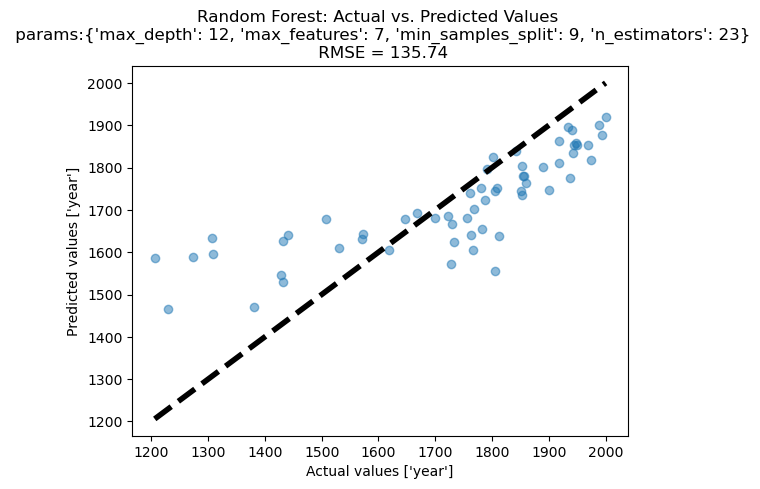

In [39]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
rf_results = pd.read_csv(rf_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_rf = rf_results.loc[rf_results["RMSE"].idxmin(), "params"]
optimal_params_rf = dict(eval(optimal_params_str_rf))

rf_opt = RandomForestRegressor(**optimal_params_rf)

y_pred_rf = rf_opt.fit(X_train, y_train).predict(X_test)

title_str = (
    f"Random Forest: Actual vs. Predicted Values \n params:"
    + optimal_params_str_rf
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_rf):.2f}"
)

param_dict = {"title": title_str}
fig_path = f"{FIGURE_PATH}avp_rf.png"
fig, ax = plt.subplots(1, 1)
rf_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_rf, param_dict, fig_path)

# PLS Regressor - RSCV


In [40]:
from sklearn import cross_decomposition

pls = cross_decomposition.PLSRegression()
pls_rscv_results_file = f"{RESULTS_PATH}/pls_rscv_results.csv"


rscv(
    features=X,
    target=y,
    model=pls,
    param_distributions=pls_rscv_parameters,
    results_file=pls_rscv_results_file,
    random_state=random_state,
)

2024-06-20 17:18:38 - INFO - Features: (194, 410), Target: (194,), Model: PLSRegression(), Param_distributions: {'n_components': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460cd7d6a0>, 'scale': [True, False], 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460cd7d430>, 'tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f460cd7cd70>, 'copy': [True]}, Results File: ../03_Modelling/03_1_rscv/rscv_results//pls_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-20 17:18:38 - INFO - Trial: 0 out of 5
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/pyt

Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 509, 'n_components': 8, 'scale': True, 'tol': np.float64(0.8700938486804547)}
Best score -128.2915494872316 for PLSRegression: -128.2915494872316
Best estimator for PLSRegression: PLSRegression(max_iter=509, n_components=8, tol=np.float64(0.8700938486804547))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/

Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 361, 'n_components': 2, 'scale': False, 'tol': np.float64(0.29038613102256156)}
Best score -179.09921499277146 for PLSRegression: -179.09921499277146
Best estimator for PLSRegression: PLSRegression(max_iter=361, scale=False, tol=np.float64(0.29038613102256156))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/

Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 367, 'n_components': 15, 'scale': False, 'tol': np.float64(0.6047186501763625)}
Best score -139.0583499464936 for PLSRegression: -139.0583499464936
Best estimator for PLSRegression: PLSRegression(max_iter=367, n_components=15, scale=False,
              tol=np.float64(0.6047186501763625))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 43
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 42
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 43
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 42
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/

Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 92, 'n_components': 10, 'scale': True, 'tol': np.float64(0.28822471504127617)}
Best score -148.32627263749353 for PLSRegression: -148.32627263749353
Best estimator for PLSRegression: PLSRegression(max_iter=92, n_components=10, tol=np.float64(0.28822471504127617))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 42
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 45
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 42
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 44
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/

Best hyperparameters for PLSRegression: {'copy': True, 'max_iter': 339, 'n_components': 12, 'scale': True, 'tol': np.float64(0.6786318868399671)}
Best score -167.2597962362981 for PLSRegression: -167.2597962362981
Best estimator for PLSRegression: PLSRegression(max_iter=339, n_components=12, tol=np.float64(0.6786318868399671))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 33
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 32
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:336: UserWarning: y residual is constant at iteration 33
  warnings.warn(f"y residual is constant at iteration {k}")
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/cross_decomposition/

,model,MAE,RMSE,params
0,PLSRegression(),155.968751,190.528573,"{'copy': True, 'max_iter': 509, 'n_components'..."
1,PLSRegression(),143.133624,178.626054,"{'copy': True, 'max_iter': 361, 'n_components'..."
2,PLSRegression(),145.001649,183.987333,"{'copy': True, 'max_iter': 367, 'n_components'..."
3,PLSRegression(),130.823532,159.924182,"{'copy': True, 'max_iter': 92, 'n_components':..."
4,PLSRegression(),116.195037,148.084669,"{'copy': True, 'max_iter': 339, 'n_components'..."


In [41]:
# generate the actual vs. predicted plot
from al_lib.helper_functions import plot_actual_vs_pred

# import the optimal model parameters
pls_results = pd.read_csv(pls_rscv_results_file)
# select the model parameters with the lowest RMSE
optimal_params_str_pls = pls_results.loc[pls_results["RMSE"].idxmin(), "params"]
optimal_params_pls = dict(eval(optimal_params_str_pls))
# fit the data with the optimal model parameters
pls_opt = cross_decomposition.PLSRegression(**optimal_params_pls)

y_pred_pls = pls_opt.fit(X_train, y_train).predict(X_test)

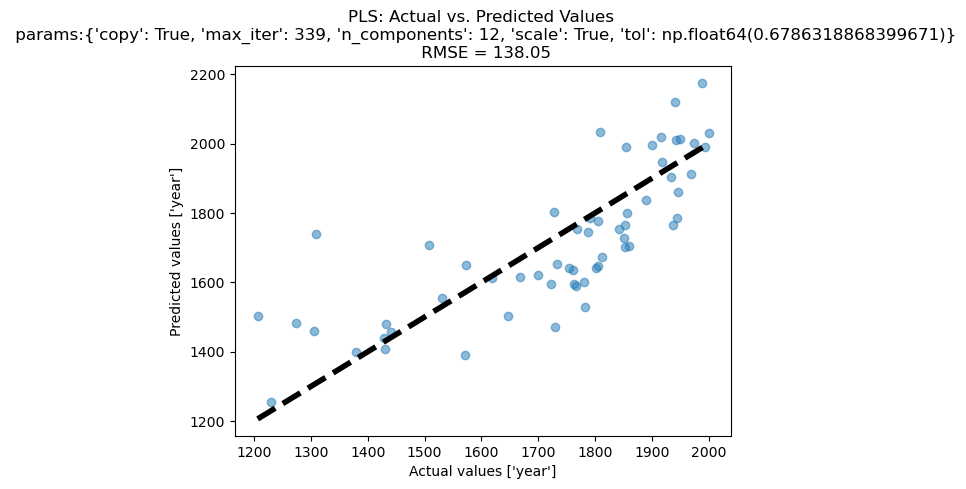

In [42]:
# plot
title_str = (
    f"PLS: Actual vs. Predicted Values \n params:"
    + optimal_params_str_pls
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_pls)):.2f}"
)

param_dict = {"title": title_str}
fig_path = (f"{FIGURE_PATH}/avp_pls.png")

fig, ax = plt.subplots(1, 1)
pls_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_pls, param_dict, fig_path)

# KKR Regressor - RSCV

In [43]:
from sklearn.kernel_ridge import KernelRidge as KRR

krr = KRR()
krr_rscv_results_file = f"{RESULTS_PATH}/krr_rscv_results.csv"

rscv(
    features=X,
    target=y,
    model=krr,
    param_distributions=krr_rscv_parameters,
    results_file=krr_rscv_results_file,
    random_state=random_state,
)

2024-06-20 17:18:49 - INFO - Features: (194, 410), Target: (194,), Model: KernelRidge(), Param_distributions: {'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f460cd7caa0>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f460cd7c4d0>, 'kernel': ['linear', 'poly', 'polynomial', 'rbf']}, Results File: ../03_Modelling/03_1_rscv/rscv_results//krr_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-20 17:18:49 - INFO - Trial: 0 out of 5
2024-06-20 17:18:50 - INFO - Trial: 1 out of 5


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.0320501174021511), 'gamma': np.float64(0.0033992529551635222), 'kernel': 'polynomial'}
Best score -196.1572193418015 for KernelRidge: -196.1572193418015
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.0320501174021511),
            gamma=np.float64(0.0033992529551635222), kernel='polynomial')


2024-06-20 17:18:51 - INFO - Trial: 2 out of 5


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.01725986770280974), 'gamma': np.float64(0.04931175288249139), 'kernel': 'rbf'}
Best score -197.07653591460476 for KernelRidge: -197.07653591460476
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.01725986770280974),
            gamma=np.float64(0.04931175288249139), kernel='rbf')


2024-06-20 17:18:53 - INFO - Trial: 3 out of 5


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.014936474039254112), 'gamma': np.float64(0.06846083730456055), 'kernel': 'poly'}
Best score -194.88808075196377 for KernelRidge: -194.88808075196377
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.014936474039254112),
            gamma=np.float64(0.06846083730456055), kernel='poly')


2024-06-20 17:18:54 - INFO - Trial: 4 out of 5


Best hyperparameters for KernelRidge: {'alpha': np.float64(0.001730054682927883), 'gamma': np.float64(0.058019946539288374), 'kernel': 'poly'}
Best score -196.92887892516615 for KernelRidge: -196.92887892516615
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.001730054682927883),
            gamma=np.float64(0.058019946539288374), kernel='poly')
Best hyperparameters for KernelRidge: {'alpha': np.float64(0.007040067793884086), 'gamma': np.float64(0.0730868413844457), 'kernel': 'poly'}
Best score -196.280935045105 for KernelRidge: -196.280935045105
Best estimator for KernelRidge: KernelRidge(alpha=np.float64(0.007040067793884086),
            gamma=np.float64(0.0730868413844457), kernel='poly')


,model,MAE,RMSE,params
0,KernelRidge(),184.875785,216.449133,"{'alpha': 0.0320501174021511, 'gamma': 0.00339..."
1,KernelRidge(),182.445557,211.952286,"{'alpha': 0.01725986770280974, 'gamma': 0.0493..."
2,KernelRidge(),183.725407,214.248238,"{'alpha': 0.014936474039254112, 'gamma': 0.068..."
3,KernelRidge(),183.001128,212.834232,"{'alpha': 0.001730054682927883, 'gamma': 0.058..."
4,KernelRidge(),182.173672,214.657518,"{'alpha': 0.007040067793884086, 'gamma': 0.073..."


In [44]:
# generate the actual vs. predicted plot

# import the optimal model parameters
krr_results = pd.read_csv(krr_rscv_results_file)

# select the model parameters with the lowest RMSE
optimal_params_str_krr = krr_results.loc[krr_results["RMSE"].idxmin(), "params"]
optimal_params_krr = dict(eval(optimal_params_str_krr))
krr_opt = KRR(**optimal_params_krr)

y_pred_krr = krr_opt.fit(X_train, y_train).predict(X_test)

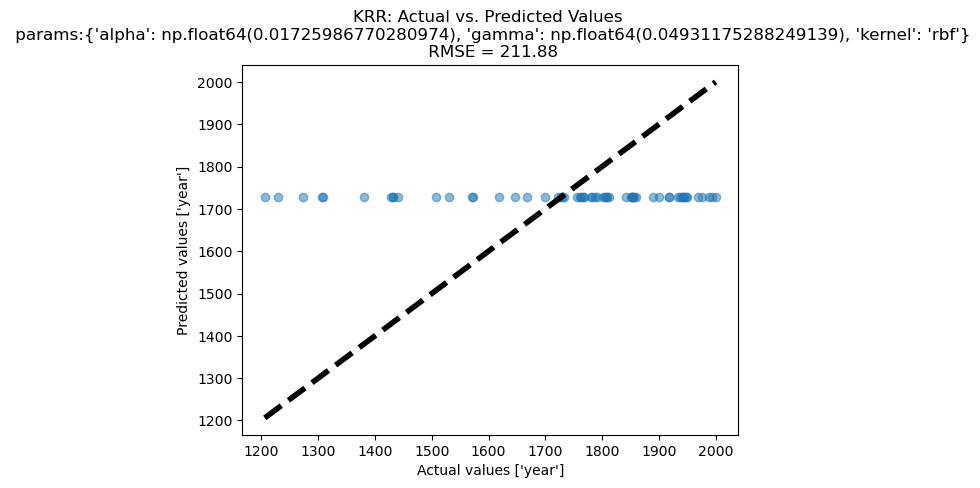

In [45]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_krr string into more lines

title_str = (
    f"KRR: Actual vs. Predicted Values \n params:"
    + optimal_params_str_krr
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_krr)):.2f}"
)

param_dict = {"title": title_str}
fig_path_krr = (f"{FIGURE_PATH}/avp_krr.png")

fig, ax = plt.subplots(1, 1)
krr_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_krr, param_dict, fig_path_krr)

# MLP Regressor - RSCV

In [46]:
# import mlp
from sklearn.neural_network import MLPRegressor as MLP

mlp = MLP()
mlp_rscv_results_file = f"{RESULTS_PATH}/mlp_rscv_results.csv"

rscv_mpl = rscv(
    features=X,
    target=y,
    model=mlp,
    param_distributions=mlp_rscv_parameters,
    results_file=mlp_rscv_results_file,
    random_state=random_state,
)

2024-06-20 17:18:55 - INFO - Features: (194, 410), Target: (194,), Model: MLPRegressor(), Param_distributions: {'hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460ccf5f40>, 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f460ccf5850>, 'early_stopping': [True, False], 'validation_fraction': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f460ccf5fa0>}, Results File: ../03_Modelling/03_1_rscv/rscv_results//mlp_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-20 17:18:55 - INFO - Trial: 0 out of 5
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Ma

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.011423210271875284), 'early_stopping': False, 'hidden_layer_sizes': 53, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.13269784027286136)}
Best score -147.47505925259156 for MLPRegressor: -147.47505925259156
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.011423210271875284),
             hidden_layer_sizes=53, solver='lbfgs',
             validation_fraction=np.float64(0.13269784027286136))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': np.float64(0.08868688607758396), 'early_stopping': True, 'hidden_layer_sizes': 50, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.19023501208659)}
Best score -162.09505397618193 for MLPRegressor: -162.09505397618193
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=np.float64(0.08868688607758396),
             early_stopping=True, hidden_layer_sizes=50, solver='lbfgs',
             validation_fraction=np.float64(0.19023501208659))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.08392412197522377), 'early_stopping': False, 'hidden_layer_sizes': 138, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.18444045740576112)}
Best score -147.50272752402594 for MLPRegressor: -147.50272752402594
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.08392412197522377),
             hidden_layer_sizes=138, solver='lbfgs',
             validation_fraction=np.float64(0.18444045740576112))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/t

Best hyperparameters for MLPRegressor: {'activation': 'identity', 'alpha': np.float64(0.08493997448345687), 'early_stopping': True, 'hidden_layer_sizes': 117, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.15126790028225476)}
Best score -152.79590639607918 for MLPRegressor: -152.79590639607918
Best estimator for MLPRegressor: MLPRegressor(activation='identity', alpha=np.float64(0.08493997448345687),
             early_stopping=True, hidden_layer_sizes=117, solver='lbfgs',
             validation_fraction=np.float64(0.15126790028225476))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.

Best hyperparameters for MLPRegressor: {'activation': 'tanh', 'alpha': np.float64(0.08614168616252865), 'early_stopping': True, 'hidden_layer_sizes': 168, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.13967450292770806)}
Best score -159.96240918340956 for MLPRegressor: -159.96240918340956
Best estimator for MLPRegressor: MLPRegressor(activation='tanh', alpha=np.float64(0.08614168616252865),
             early_stopping=True, hidden_layer_sizes=168, solver='lbfgs',
             validation_fraction=np.float64(0.13967450292770806))


/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [48]:
# generate the actual vs. predicted plot

# import the optimal model parameters
mlp_results = pd.read_csv(mlp_rscv_results_file)

# select the (optimal) model parameters with the lowest RMSE
optimal_params_str_mlp = mlp_results.loc[mlp_results["RMSE"].idxmin(), "params"]
optimal_params_mlp = dict(eval(optimal_params_str_mlp))

# fit the data with the optimal model parameters
mlp_opt = MLP(**optimal_params_mlp)

y_pred_mlp = mlp_opt.fit(X_train, y_train).predict(X_test)

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


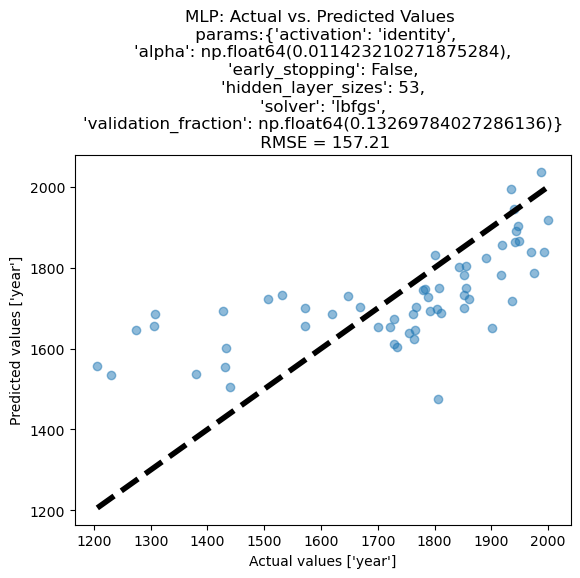

In [49]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_mlp string into more lines
optimal_params_str_mlp_break = optimal_params_str_mlp.replace(", ", ",\n")

title_str = (
    f"MLP: Actual vs. Predicted Values \n params:"
    + optimal_params_str_mlp_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_mlp)):.2f}"
)

param_dict = {"title": title_str}
fig_path_mlp = (f"{FIGURE_PATH}/avp_mlp.png")

fig, ax = plt.subplots(1, 1)
mlp_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_mlp, param_dict, fig_path_mlp)

In [50]:
# import xgboost
import xgboost as xgb
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb_rscv_results_file = f"{RESULTS_PATH}/xgb_rscv_results.csv"

rscv_xgb = rscv(
    features=X,
    target=y,
    model=xgb,
    param_distributions=xgb_rscv_parameters,
    results_file=xgb_rscv_results_file,
    random_state=random_state,
)

2024-06-20 17:29:07 - INFO - Features: (194, 410), Target: (194,), Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), Param_distributions: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460ccf43b0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete

Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.8751066514766339), 'gamma': np.float64(0.16818167523220662), 'learning_rate': np.float64(0.05712606497679705), 'max_depth': 4, 'n_estimators': 51, 'reg_alpha': np.float64(0.43490118800587857), 'reg_lambda': np.float64(0.18431270733966665), 'subsample': np.float64(0.5474328312394807)}
Best score -131.90149412175165 for XGBRegressor: -131.90149412175165
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.8751066514766339), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.16818167523220662), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.05712606497679705), max_bin=None,
             max_c

/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-06-20 17:30:29 - INFO - Trial: 2 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.8906452289570015), 'gamma': np.float64(0.10669662799959706), 'learning_rate': np.float64(0.045885391240277726), 'max_depth': 15, 'n_estimators': 96, 'reg_alpha': np.float64(0.288849310803141), 'reg_lambda': np.float64(0.1900529560176134), 'subsample': np.float64(0.5241705645075243)}
Best score -132.3192245299745 for XGBRegressor: -132.3192245299745
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.8906452289570015), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.10669662799959706), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.045885391240277726), max_bin=None,
             max_cat

2024-06-20 17:31:06 - INFO - Trial: 3 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.7592698722226102), 'gamma': np.float64(0.31609219659486265), 'learning_rate': np.float64(0.07601437623115746), 'max_depth': 2, 'n_estimators': 87, 'reg_alpha': np.float64(0.2758861085585976), 'reg_lambda': np.float64(0.20718059711203507), 'subsample': np.float64(0.8991741112440934)}
Best score -118.26016458198868 for XGBRegressor: -118.26016458198868
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7592698722226102), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.31609219659486265), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.07601437623115746), max_bin=None,
             max_ca

2024-06-20 17:31:41 - INFO - Trial: 4 out of 5


Best hyperparameters for XGBRegressor: {'colsample_bytree': np.float64(0.7935339210988364), 'gamma': np.float64(0.2735944598929348), 'learning_rate': np.float64(0.10964563768405512), 'max_depth': 5, 'n_estimators': 36, 'reg_alpha': np.float64(0.4136984736516216), 'reg_lambda': np.float64(0.04940426012404331), 'subsample': np.float64(0.8186584488972437)}
Best score -118.53705217830888 for XGBRegressor: -118.53705217830888
Best estimator for XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7935339210988364), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(0.2735944598929348), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.10964563768405512), max_bin=None,
             max_cat_

In [51]:
# generate the actual vs. predicted plot

# import the optimal model parameters
xgb_results = pd.read_csv(xgb_rscv_results_file)

# round the results to 4 decimal places
xgb_results = xgb_results.round(4)

# select the model parameters with the lowest RMSE
optimal_params_str_xgb = xgb_results.loc[xgb_results["RMSE"].idxmin(), "params"]
optimal_params_xgb = dict(eval(optimal_params_str_xgb))

# fit the data with the optimal model parameters
xgb_opt = XGBRegressor(**optimal_params_xgb)

y_pred_xgb = xgb_opt.fit(X_train, y_train).predict(X_test)

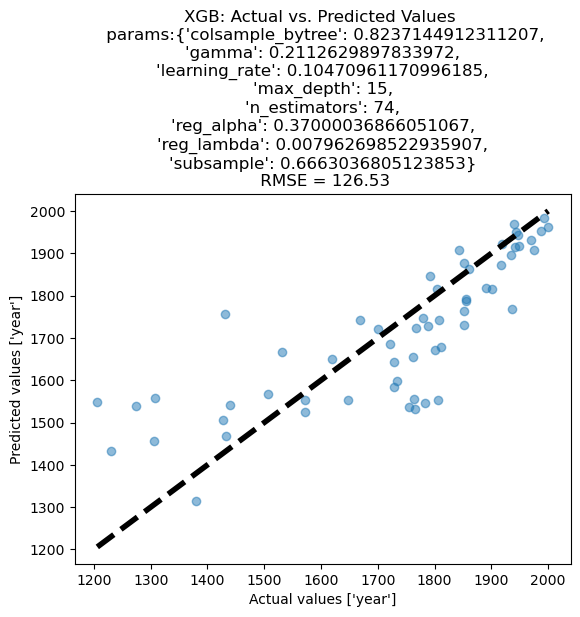

In [52]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_xgb_break = optimal_params_str_xgb.replace(", ", ",\n")


title_str = (
    f"XGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_xgb_break
    + f"\n RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}"
)

param_dict = {"title": title_str}
fig_path = (f"{FIGURE_PATH}/avp_xgb.png")

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict)

# HGB

In [53]:
# HGB
from sklearn.ensemble import HistGradientBoostingRegressor as HGB

hbg = HGB()
hgb_rscv_results_file = f"{RESULTS_PATH}/hgb_rscv_results.csv"

rscv_hgb = rscv(
    features=X,
    target=y,
    model=hbg,
    param_distributions=hgb_rscv_parameters,
    results_file=hgb_rscv_results_file,
    random_state=random_state,
)

2024-06-20 17:33:09 - INFO - Features: (194, 410), Target: (194,), Model: HistGradientBoostingRegressor(), Param_distributions: {'loss': ['squared_error'], 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f460ccf6360>, 'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460ccf5c70>, 'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460ccf6870>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f460ccf66c0>}, Results File: ../03_Modelling/03_1_rscv/rscv_results//hgb_rscv_results.csv Random_state: RandomState(MT19937), NoTrials: 5, nfolds: 4, n_jobs: 5, Scoring: make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')
2024-06-20 17:33:09 - INFO - Trial: 0 out of 5
2024-06-20 17:33:56 - INFO - Trial: 1 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.06436907797889511), 'loss': 'squared_error', 'max_iter': 214, 'max_leaf_nodes': 77, 'min_samples_leaf': 29}
Best score -133.24399251215553 for HistGradientBoostingRegressor: -133.24399251215553
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.06436907797889511),
                              max_iter=214, max_leaf_nodes=77,
                              min_samples_leaf=29)


2024-06-20 17:34:41 - INFO - Trial: 2 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.019480333655872553), 'loss': 'squared_error', 'max_iter': 487, 'max_leaf_nodes': 41, 'min_samples_leaf': 30}
Best score -123.63314219206009 for HistGradientBoostingRegressor: -123.63314219206009
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.019480333655872553),
                              max_iter=487, max_leaf_nodes=41,
                              min_samples_leaf=30)


2024-06-20 17:35:40 - INFO - Trial: 3 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.10757886431481932), 'loss': 'squared_error', 'max_iter': 435, 'max_leaf_nodes': 71, 'min_samples_leaf': 30}
Best score -127.8885886242884 for HistGradientBoostingRegressor: -127.8885886242884
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.10757886431481932),
                              max_iter=435, max_leaf_nodes=71,
                              min_samples_leaf=30)


2024-06-20 17:36:32 - INFO - Trial: 4 out of 5


Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.08529442962059498), 'loss': 'squared_error', 'max_iter': 404, 'max_leaf_nodes': 57, 'min_samples_leaf': 27}
Best score -125.43253085291538 for HistGradientBoostingRegressor: -125.43253085291538
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.08529442962059498),
                              max_iter=404, max_leaf_nodes=57,
                              min_samples_leaf=27)
Best hyperparameters for HistGradientBoostingRegressor: {'learning_rate': np.float64(0.06358880936429621), 'loss': 'squared_error', 'max_iter': 123, 'max_leaf_nodes': 98, 'min_samples_leaf': 34}
Best score -129.84192770692619 for HistGradientBoostingRegressor: -129.84192770692619
Best estimator for HistGradientBoostingRegressor: HistGradientBoostingRegressor(learning_rate=np.float64(0.06358880936429621),
                              max_iter=123, max_leaf_nodes=98,
       

In [54]:
# generate the actual vs. predicted plot
hgb_results = pd.read_csv(hgb_rscv_results_file)

# select the model parameters with the lowest RMSE
# select the model parameters with the lowest RMSE
optimal_params_str_hgb = hgb_results.loc[hgb_results["RMSE"].idxmin(), "params"]
optimal_params_hgb = dict(eval(optimal_params_str_hgb))

# fit the data with the optimal model parameters
hgb_opt = HGB(**optimal_params_hgb)

y_pred_hgb = hgb_opt.fit(X_train, y_train).predict(X_test)

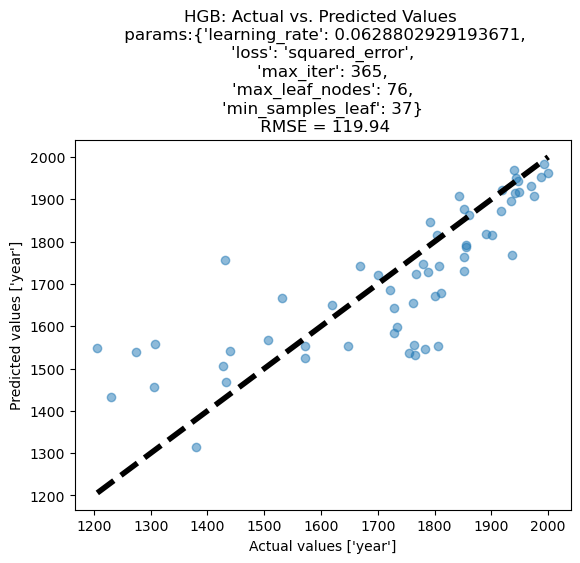

In [55]:
# plot
from al_lib.helper_functions import plot_actual_vs_pred

# break the optimal_params_str_ string into more lines
optimal_params_str_hgb_break = optimal_params_str_hgb.replace(", ", ",\n")


title_str = (
    f"HGB: Actual vs. Predicted Values \n params:"
    + optimal_params_str_hgb_break
    + f"\n RMSE = {root_mean_squared_error(y_test, y_pred_hgb):.2f}"
)
fig_path = (f"{FIGURE_PATH}/avp_xgb.png")
param_dict = {"title": title_str}

fig, ax = plt.subplots(1, 1)
xgb_avp_plot = plot_actual_vs_pred(ax, y_test, y_pred_xgb, param_dict, fig_path)

# Quality Control

In this section the goal is to document the packages which where used during the execution of this notebook

In [56]:
## Package informations
from sklearn import show_versions

show_versions()


System:
    python: 3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]
executable: /home/fhwn.ac.at/202375/.conda/envs/thesis/bin/python
   machine: Linux-5.15.0-101-generic-x86_64-with-glibc2.31

Python dependencies:
      sklearn: 1.5.0
          pip: 24.0
   setuptools: 70.0.0
        numpy: 2.0.0
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 80
         prefix: libopenblas
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libopenblasp-r0.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: SkylakeX

       user_api: openmp
   internal_api: openmp
    num_threads: 80
         prefix: libgomp
       filepath: /home/fhwn.ac.at/202375/.conda/envs/thesis/lib/libgomp.so.1.0.0
        version: None


In [57]:
import subprocess
import os
import datetime

# Add data/time information
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

# Create the output name from the notebookname

output_name = f"{notebook_name.split('.')[0]}_{date}.html"


# Function to convert the notebook to HTML
def convert_notebook_to_html(notebook_name, output_name):
    # Use subprocess to call the jupyter nbconvert command
    subprocess.call(["jupyter", "nbconvert", "--to", "html", notebook_name])
    # Rename the output file
    os.rename(notebook_name.split(".")[0] + ".html", output_name)


# Wait for a short period to ensure all cells have finished executing
time.sleep(5)  # Adjust the sleep duration as needed

# Convert the notebook to HTML
convert_notebook_to_html(notebook_name, output_name)

[NbConvertApp] Converting notebook 03_1_rscv.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 1340246 bytes to 03_1_rscv.html
